<a href="https://colab.research.google.com/github/FerRojas00/Proyecto_Integrador/blob/main/Avance6_Equipo_26_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**
## Proyecto Integrador (Gpo 26)
> ### Tecnológico de Monterrey
>### Avance 6 - **Conclusiones Clave**


## -

## **Automatización del Registro de Materiales Médicos mediante Visión Computacional**

### *EQUIPO* 26


* ### Luis Fernando Rojas Marta - A00757351
* ### Jose Eduardo Carreon - A01372413


### **Carga e Instalacion de Librerias y Modelos:**
Ejecutar una sola vez

In [ ]:
# Instalacion de Librerias de YOLO y EasyOCR
!pip install ultralytics
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
# Montaje de la Unidad de Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importacion de las Librerias
from ultralytics import YOLO
import cv2
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import time
from PIL import Image
import easyocr
from datetime import datetime
from difflib import SequenceMatcher

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Funciones para el procesado de imagenes:**
-Ejectuar una sola vez.


In [ ]:
####################
'''
FUNCIONES y MODELO:
'''
####################

#### Carga del modelo
model = YOLO("/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/YOLOv8_resultados50EPOCH/train/weights/best.pt") # Direccion Fer
#/content/drive/MyDrive/08_Proyecto_Integrador/Shared/Labels/Analisis_Precision/


#### ##### RUTINA PRINCIPAL ######
def procesar_imagen_con_etiquetas(ruta_imagen, etiquetas=["REF", "LOT", "FABRICACION", "CADUCIDAD"], confianza_threshold=0.60):
    #IMAGEN: Cargar la imagen
    image = cv2.imread(ruta_imagen)

    #YOLO: Inferencia
    results = model(image)[0]

    #OCR: Inicializar lector OCR
    reader = easyocr.Reader(['en'])  #Agregar  'es' si se requiere para las Tags

    resultados = []

    for i in range(len(results.boxes)):
        conf = results.boxes.conf[i].item()
        if conf < confianza_threshold:         #Se revisa que la confianza de la inferencia sea mayor al Threshold (default= 60%)
            print(f"[Descartado] Corte #{i+1} - Confianza: {conf:.2f}")
            continue

        #RECORTE: Crop a imagen
        x1, y1, x2, y2 = map(int, results.boxes.xyxy[i].tolist())
        crop = image[y1:y2, x1:x2]

        #OCR para este crop
        ocr_result = reader.readtext(crop)
        textos = [res[1] for res in ocr_result]
        results_df = pd.DataFrame(textos, columns=["Text"])

        #EXTRACCION FECHAS si es necesario
        incluir_fab = "FABRICACION" in etiquetas
        incluir_cad = "CADUCIDAD" in etiquetas
        fab_fecha, cad_fecha = None, None
        if incluir_fab or incluir_cad:
            fab_fecha, cad_fecha = extraer_fechas(results_df)

        #EXTRACCION TAGS OCR reales
        etiquetas_ocr = [et for et in etiquetas if et not in ["FABRICACION", "CADUCIDAD"]]
        valores = extraer_valores_por_tag(results_df, etiquetas_ocr)

        if incluir_fab:
            valores["FABRICACION"] = fab_fecha
        if incluir_cad:
            valores["CADUCIDAD"] = cad_fecha

        #CONSTRUCCION entrada del resultado
        resultado = {
            "corte": len(resultados) + 1,
            "valores": valores,
            "crop": crop,
            "confianza": conf
        }
        resultados.append(resultado)
        print(f"[Agregado] Corte #{resultado['corte']} - Confianza: {conf:.2f}")

    return resultados



###### Funcion para extraer fechas en formato AAAA-MM-DD
def extraer_fechas(results_df):
    #Uso de Regex para el formato de fecha
    fecha_patron = r"\b\d{4}-\d{2}-\d{2}\b"
    fechas = []

    for idx, texto in results_df["Text"].items():
        if pd.isna(texto):
            continue

        #Buscar fechas en el texto
        fechas_encontradas = re.findall(fecha_patron, texto)
        fechas.extend(fechas_encontradas)

    #Eliminar duplicados y ordenar por fecha
    fechas = sorted(list(set(fechas)))

    #Determinar FAB y CAD
    fab_fecha = fechas[0] if len(fechas) > 0 else "NA"
    cad_fecha = fechas[1] if len(fechas) > 1 else "NA"

    return fab_fecha, cad_fecha



###### Funcion para buscar valores por etiquetas
def extraer_valores_por_tag(results_df, tags):
    valores = {tag: "NA" for tag in tags}

    for tag in tags:
        for idx, texto in results_df["Text"].items():
            if pd.isna(texto):
                continue

            #Se limpia el texto para comparacion
            clean_texto = texto.upper().replace("[", "").replace("]", "")

            #Caso 1: Si es exactamente igual (etiqueta sola), tomamos siguiente entrada
            if clean_texto.strip() == tag:
                if idx + 1 in results_df.index:
                    valores[tag] = results_df.loc[idx + 1, "Text"]
                break

            #Caso 2:Si la etiqueta viene combinada con el valor
            elif tag in clean_texto:
                match = re.search(rf"{tag}\s*[:\-]?\s*([A-Z0-9]+)", clean_texto)
                if match:
                    valores[tag] = match.group(1)
                    break
                partes = clean_texto.split()
                if len(partes) > 1 and tag in partes[0]:
                    valores[tag] = partes[1]
                    break

    return valores


####### Consrtuccion de fila en el Dataframe
def construir_fila_dataframe(ruta_imagen, valores_dict):
    fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    base_fila = {
        "imagen": os.path.basename(ruta_imagen),
        "fecha_procesado": fecha_actual,
        "REF": valores_dict.get("REF", "NA"),
        "LOT": valores_dict.get("LOT", "NA"),
        "FABRICACION": valores_dict.get("FABRICACION", "NA"),
        "CADUCIDAD": valores_dict.get("CADUCIDAD", "NA")
    }

    #Agregar si hay etiquetas adicionales
    etiquetas_extra = [k for k in valores_dict if k not in base_fila]
    for extra in etiquetas_extra:
        base_fila[extra] = valores_dict[extra]

    return pd.DataFrame([base_fila])

###### Guardado en un CSV
def guardar_en_csv(df_fila, nombre_csv="/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/datos_etiquetas.csv"):
    if os.path.exists(nombre_csv):
        df_fila.to_csv(nombre_csv, mode='a', header=False, index=False)
    else:
        df_fila.to_csv(nombre_csv, mode='w', header=True, index=False)


##### Mostrado de Recortss
def mostrar_recortes(resultados):
    for res in resultados:
        plt.imshow(cv2.cvtColor(res["crop"], cv2.COLOR_BGR2RGB))
        plt.title(f"Corte # {res['corte']} - Confianza: {res['confianza']:.2f}: ")
        plt.axis('off')
        plt.show()

#########################################
#### Normalizado de valores:

def normalizar_valor(valor):
    """
    Limpiar el valor borrando caracteres como parentesis,dos puntos, espacios y convirtiendo todo a mayusculas para mejor comparacion
    """
    if isinstance(valor, str):
        valor = valor.upper().strip()
        valor = re.sub(r"[^\w\-]", "", valor)  # Se elimina todo excepto letras, nnmeros y guiones
        return valor
    return str(valor)

### Calculo de Similitud:

def similitud_texto(val1, val2):
    v1 = normalizar_valor(val1)
    v2 = normalizar_valor(val2)
    return SequenceMatcher(None, v1, v2).ratio()  # valor entre 0.0 y 1.0

## **ETAPA 1: Evaluar desempeño según número de etiquetas**

Propósito:
> Validar si la complejidad visual (cantidad de etiquetas por imagen) afecta la precisión.

1.   Evaluacion de Imagenes con distinto numero de etiquetas.


## **Una imagen con una etiqueta:**
Etiqueta Individual

In [ ]:
#RUTA: de la Imagen a procesar:
ruta = "/content/drive/MyDrive/08_Proyecto_Integrador/Label_Photos/Label_60.jpg"
#TAGS: Etiquetas que buscar:
etiquetas = ["REF", "LOT", "CADUCIDAD", "FABRICACION", "CANTIDAD"]


#PASO 1: Procesar la imagen
resultados = procesar_imagen_con_etiquetas(ruta, etiquetas)

#IMPRESION y GUARDADO: Mostrado de resultados
for res in resultados:
    print(f"\nCorte # {res['corte']} - Confianza: {res['confianza']:.2f}):")
    valores = res["valores"]

    for etiqueta, valor in res["valores"].items():
        print(f"{etiqueta}: {valor}")

    #PASO 2: Crear la fila del Dataframe
    fila = construir_fila_dataframe(ruta, valores)
    display(fila)  #Mostrar la tabla

    #PASO 3: Guardar en el CSV
    guardar_en_csv(fila)


0: 640x480 1 etiqueta, 350.2ms
Speed: 18.0ms preprocess, 350.2ms inference, 30.9ms postprocess per image at shape (1, 3, 640, 480)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[Agregado] Corte #1 - Confianza: 0.84

Corte # 1 - Confianza: 0.84):
REF: (240)11731629322
LOT: (10)79121605
CANTIDAD: NA
FABRICACION: 2024-10-09
CADUCIDAD: 2025-09-30


,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_60.jpg,2025-06-08 04:02:06,(240)11731629322,(10)79121605,2024-10-09,2025-09-30,NA


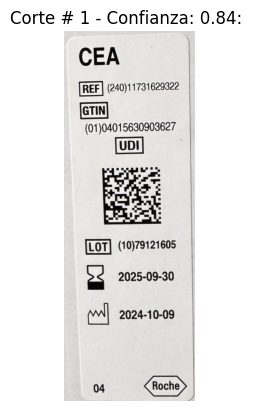

In [ ]:

#Mostrar cada recorte detectado
mostrar_recortes(resultados)

## **ETAPA 2: Heatmaps separados de confianza (OCR vs YOLO)**

Objetivo:
> **Heatmap 1:** Mostrar como afecta la distancia/iluminacion a la confianza del OCR.
> **Heatmap 2: **Mostrar como  se afecta a la confianza del modelo de inferencia de YOLOv8.


Analisis de Imagenes para Comparativa de Lux y Dist.


In [ ]:
# Cargar datos
ruta_base = "/content/drive/MyDrive/08_Proyecto_Integrador/Shared/Labels/Analisis_Precision_r1/"
ruta_csv = os.path.join(ruta_base, "tabla_datos_r2.csv")
df_esperados = pd.read_csv(ruta_csv)
df_esperados.columns = [col.strip().upper().replace(" ", "_") for col in df_esperados.columns]

# Inicializar lista de resultados
resultados_confianza = []

# Recorrer cada imagen
for _, row in df_esperados.iterrows():
    nombre_img = row["NAME"]
    ruta_imagen = os.path.join(ruta_base, nombre_img)

    # Inferencia y OCR
    resultados_ocr = procesar_imagen_con_etiquetas(ruta_imagen, etiquetas=["REF", "LOT", "FABRICACION", "CADUCIDAD"])

    # Guardar confianzas por recorte válido
    confs_yolo = []
    confs_ocr = []

    for resultado in resultados_ocr:
        conf_yolo = resultado["confianza"]
        confs_yolo.append(conf_yolo)

        crop_texts = resultado.get("valores", {})
        for val in crop_texts.values():
            if isinstance(val, str) and val.strip() != "NA":
                confs_ocr.append(conf_yolo)  # se usa confianza del corte como proxy OCR

    # Calcular promedios por imagen
    promedio_yolo = np.mean(confs_yolo) if confs_yolo else 0
    promedio_ocr = np.mean(confs_ocr) if confs_ocr else 0

    resultados_confianza.append({
        "NAME": nombre_img,
        "LUX": row["LUX"],
        "DISTANCIA_CM": row["DISTANCIA_(CM)"],
        "CONF_YOLO": promedio_yolo,
        "CONF_OCR": promedio_ocr
    })

# Crear DataFrame final
df_confianza = pd.DataFrame(resultados_confianza)

# Mapeo de LUX a etiquetas
def categorizar_lux(lux):
    if lux <= 200:
        return "<200 Lux (Baja)"
    elif lux <= 300:
        return "250 Lux (Media)"
    else:
        return ">300 (Alta)"

df_confianza["LUX_RANGO"] = df_confianza["LUX"].apply(categorizar_lux)
df_confianza["DIST_ETIQUETA"] = df_confianza["DISTANCIA_CM"].astype(str) + " cm"

#### Visualizacion de Heatmaps tras procesamiento:

In [ ]:
# Definir orden fijo de columnas
orden_lux = ["Baja", "Media", "Alta"]

# Heatmap de OCR
pivot_ocr = df_confianza.pivot_table(
    values="CONF_OCR", index="DIST_ETIQUETA", columns="LUX_RANGO", aggfunc="mean"
).reindex(columns=orden_lux) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_ocr, annot=True, fmt=".0f", cmap="YlOrBr", cbar_kws={'label': 'Confianza OCR (%)'})
plt.title("Heatmap de Confianza Promedio del OCR por Distancia e Iluminación")
plt.xlabel("Iluminación")
plt.ylabel("Distancia")
plt.show()

# Heatmap de YOLO
pivot_yolo = df_confianza.pivot_table(
    values="CONF_YOLO", index="DIST_ETIQUETA", columns="LUX_RANGO", aggfunc="mean"
).reindex(columns=orden_lux) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_yolo, annot=True, fmt=".0f", cmap="BuGn", cbar_kws={'label': 'Confianza YOLO (%)'})
plt.title("Heatmap de Confianza Promedio de Detección YOLO por Distancia e Iluminación")
plt.xlabel("Iluminación")
plt.ylabel("Distancia")
plt.show()

TEST 3

In [ ]:
df_resultados